# Algorithm 1

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import pandas as pd
import seaborn as sns

# Implement the algorithm

In [60]:
class Algorithm:
    
    def __init__(self, N=20, M=10, t_1=10, epsilon=1, epsilon_0=1, beta=1, k=0.5, rho=3, d=1, theta_star=0):
        # Set up the parameters for future runs
        self.N = N
        self.M = M
        self.t_1 = t_1
        self.epsilon = epsilon
        self.epsilon_0 = epsilon_0
        self.beta = beta
        self.k = k
        self.rho = rho
        self.d = 1
        self.N_tilde = N + M
        self.X_tilde = (N, M, k, beta)
        self.t_0 = 0
        self.c_0 = 1
        
        
    def f(self, param, y, scale=1):
        return scipy.stats.norm.pdf(y, loc = param, scale = scale)
    
    def G_tilde(self, t_p, nu, w_tilde):
        i = np.argmax(w_tilde)
        return nu[i]

    def G(self, t_p, teta, w):
        return sum([teta[i] * w[i] for i in range(len(teta))]) / sum(w)
    
    def F_tilde(self, nu_bar, epsilon_p=0, X_bar=0, t_p=0):
        return np.linspace(nu_bar - 350 * epsilon_p / self.K_(self.N_tilde), nu_bar + 350 * epsilon_p / self.K_(self.N_tilde), num=self.N_tilde) # change for larger dimension

    def F(self, nu_bar, xi_p=0, X_bar=0, t_p=0):
        return np.linspace(nu_bar - 350 * xi_p / self.K_(self.N), nu_bar + 350 * xi_p / self.K_(self.N), num=self.N)
    
    def t_(self, p, former_t_p):
        return former_t_p + max(int((self.k**(-2) - 1) * former_t_p) + 1, self.t_1)

    def epsilon_(self, p):
        # d ?
        return self.epsilon_0 * min(1, (p**(-1) * self.rho * np.log(p + 1))**(1 / (self.d + self.beta)))

    def c_(self, p):
        if p==0:
            return 1
        return min(((1 + self.k) / (2 * self.k))**p, p**((1 + self.epsilon) / 2))

    def K_(self, N):
        k = 1
        while k**self.d <= self.N:
            k += 1
        return k - 1
    
    
    def plot(self, time_interval, theta_star, scale, observation, theta, w, fig):
        # plot the real law
        x_density = np.linspace(-100,100,100) 
        y_density = 15 * scipy.stats.norm.pdf(x_density, loc=theta_star, scale=scale) 
        plt.clf()
        plt.plot(x_density, y_density) #plot real density function
        plt.scatter(theta, np.zeros(self.N), c="red")
        plt.scatter([observation], [15 * scipy.stats.norm.pdf(observation, loc=theta_star, scale=scale)], marker="*") # plot observation
        plt.bar(theta, w)
        fig.canvas.draw()
        plt.pause(time_interval)
        
    def bayes_update(self, distrib, support, f, scale, observation):
        distrib = [distrib[i] * self.f(support[i], observation, scale=scale) for i in range(len(support))]
        sum_distrib = np.sum(distrib)
        distrib = [distrib[i] / sum_distrib for i in range(len(support))] # normalize
        
        return distrib



    
    def animate_pi_without_support(self, nb_iterations=10000, time_interval=0.001, theta_star=0, scale=20):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.normal(theta_star, scale, nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                q += 1
                xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                theta_hat = theta_bar
                theta = self.F(theta_hat, xi)
                w = np.ones(self.N)
                p += 1
                t_p = self.t_(p, t_p)
                

        ########## plotting
            if t % 10 == 0:
                self.plot(time_interval, theta_star, scale, observation = Y[t], theta=theta, w=w, fig=fig)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            
    def animate_pi(self, nb_iterations=10000, time_interval=0.001, theta_star=0, scale=20):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.normal(theta_star, scale, nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                nu_bar = self.G_tilde(t_p, nu, w_tilde)
                if (theta_bar - nu_bar) <= 2 * self.epsilon_(p):
                    q += 1
                    xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                    theta_hat = theta_bar
                else:
                    q = 1
                    xi = self.epsilon_(p)
                    theta_hat = nu_bar
                theta = self.F(theta_hat, xi)
                nu = self.F_tilde(nu_bar, self.epsilon_(p))
                w = np.ones(self.N)
                w_tilde = np.ones(self.N_tilde)
                p += 1
                t_p = self.t_(p, t_p)
        
    
        ########## plotting
            if t % 10 == 0:
                self.plot(time_interval, theta_star, scale, observation = Y[t], theta=theta, w=w, fig=fig)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            w_tilde = self.bayes_update(w_tilde, nu, self.f, scale, Y[t])


    
    def run_without_aux(self, nb_iterations, theta_star=0, scale=20):
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.normal(theta_star, scale, nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        
        list_of_support = []
        list_of_distrib = []
        
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                theta_bar = self.G(t_p, theta, w)
                q += 1
                xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                theta_hat = theta_bar
                theta = self.F(theta_hat, xi)
                w = np.ones(self.N)
                p += 1
                t_p = self.t_(p, t_p)
                


            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            list_of_distrib.append(w)
            list_of_support.append(theta)
            
        
        return list_of_support, list_of_distrib
    
    def run(self, nb_iterations, theta_star=0, scale=20):
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.normal(theta_star, scale, nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        
        list_of_support = []
        list_of_distrib = []
        
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                theta_bar = self.G(t_p, theta, w)
                nu_bar = self.G_tilde(t_p, nu, w_tilde)
                if (theta_bar - nu_bar) <= 2 * self.epsilon_(p):
                    q += 1
                    xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                    theta_hat = theta_bar
                else:
                    q = 1
                    xi = self.epsilon_(p)
                    theta_hat = nu_bar
                theta = self.F(theta_hat, xi)
                nu = self.F_tilde(nu_bar, self.epsilon_(p))
                w = np.ones(self.N)
                w_tilde = np.ones(self.N_tilde)
                p += 1
                t_p = self.t_(p, t_p)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            w_tilde = self.bayes_update(w_tilde, nu, self.f, scale, Y[t])
            list_of_distrib.append(w)
            list_of_support.append(theta)
        
        return list_of_support, list_of_distrib


    
    
    
        

# Animations

In [79]:
%matplotlib inline

In [80]:
test = Algorithm()

Using matplotlib backend: MacOSX
PERTURBATION
PERTURBATION
PERTURBATION
PERTURBATION


KeyboardInterrupt: 

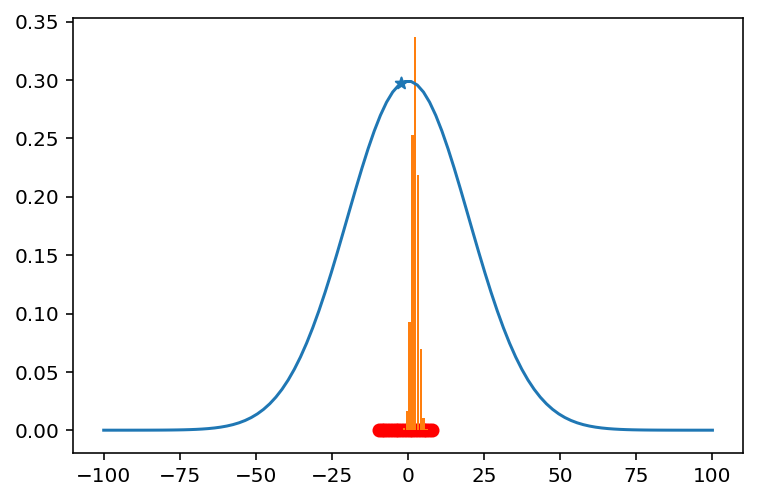

In [81]:
%matplotlib
test.animate_pi()

In [82]:
%matplotlib
test.animate_pi_without_support()

Using matplotlib backend: MacOSX
PERTURBATION
PERTURBATION
PERTURBATION
PERTURBATION


KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

# Convergence rates

## Wasserstein

In [61]:
def wassertein(alg, nb_tests, nb_iterations, theta_star=0, aux=True):
    df = pd.DataFrame(columns=["n", "distance"])

    for _ in range(nb_tests):
        if aux:
            list_of_support, list_of_distrib = alg.run(nb_iterations, theta_star)
        else:
            list_of_support, list_of_distrib = alg.run_without_aux(nb_iterations, theta_star)

        list_of_distances = [scipy.stats.wasserstein_distance(list_of_support[i], [theta_star], list_of_distrib[i], [1]) for i in range(len(list_of_support))]
        new_df = pd.DataFrame(columns=["n", "distance"])
        new_df["distance"] = np.array(list_of_distances)
        new_df["n"] = np.array([i for i in range(len(list_of_distances))])
        df = pd.concat([df, new_df])

    return df
        

In [62]:
alg = Algorithm()

In [10]:
df = wassertein(alg, 1, 10000, 0)

PERTURBATION
PERTURBATION
PERTURBATION
PERTURBATION
PERTURBATION


In [11]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


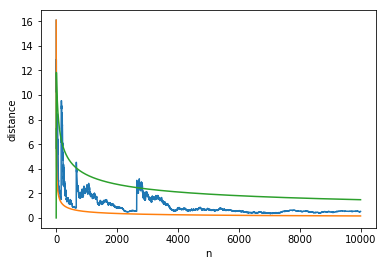

In [13]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [74]:
alg3 = Algorithm()

In [75]:
df = wassertein(alg, 1, 10000, 0, aux=False)

In [76]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


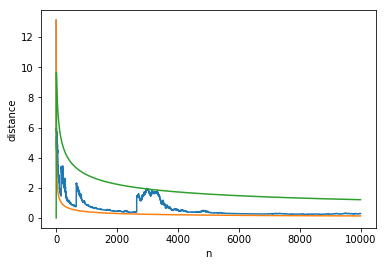

In [78]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


## Convergence presque-sûr

In [33]:
def check_concentration(alg, speed, N_samples_for_estimation, n, step=30, number_of_trials_per_step=10, theta_star=0, aux=True):
    df = pd.DataFrame(columns=["n", "proba"])
    for trial in range(number_of_trials_per_step):
        if aux:
            list_of_support, list_of_distrib = alg.run(n, theta_star)
        else:
            list_of_support, list_of_distrib = alg.run_without_aux(n, theta_star)
        for i in range(1, n, step): # begins at 3 because we remove 2 lines
            support = list_of_support[i]
            distrib = list_of_distrib[i]
            count_inside_ball = 0
            for k in range(N_samples_for_estimation):
                count_inside_ball += np.linalg.norm(np.random.choice(support, p=distrib) - theta_star)< 1 / speed(i)
            df2 = pd.DataFrame([[i, count_inside_ball / N_samples_for_estimation]],columns=['n', 'proba'])
            df = pd.concat([df,df2])
    sns.barplot(x='n', y="proba", data = df)

In [34]:
alg2 = Algorithm()

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


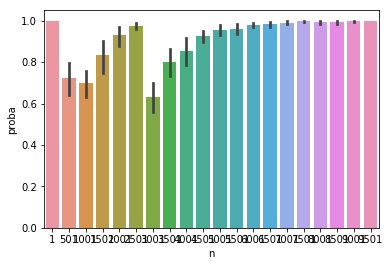

In [42]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*np.log(x), 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


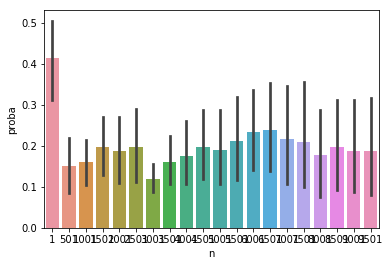

In [43]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*np.sqrt(x), 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


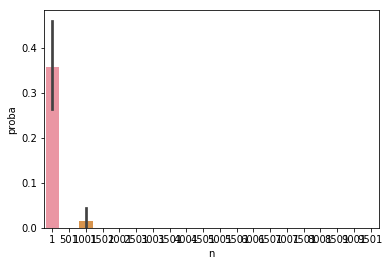

In [44]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*x, 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);